{[Click here to read this notebook in GitHub](https://colab.research.google.com/drive/1nmcirlIlf-aZRkt4nqhRrrwCcCL6u0bf)}

<head><link rel = "stylesheet" href = "https://github.com/gsolaril/topCMC/blob/main/Main%20report.ipynb"></head>

<table class = "header"><tr>
    <th align = "left">Profluent recruitment test, 2022\04\12</th>
    <th align = "right">Written by: Gaston Solari Loudet</th>
</tr></table>

### <center>Performance analysis of top-50 market capitalization cryptocurrencies</center>

The objective of this notebook is to measure certain variables that may indicate the performance of those 50 cryptoassets which have the largest circulating value in terms of fiat currency. Special interest has been considered in calculating certain "alpha" metrics provided by Z. Kakushadze from "Quantigic Solutions LLC(R)" in the paper <a href = "https://arxiv.org/ftp/arxiv/papers/1601/1601.00991.pdf">from this link</a>. This notebook will then take the structure of a backtesting procedure and report, as much as it is possible.

#### Libraries and imports

The next code cell prepares the required functions and classes to be used in the rest of the document. There are two custom added features for this purpose:
* "**Appendix.py**" file, which holds the "`Alpha`" calculators and all the needed "`Appendix`" time series common functions found in the appendix of the document itself.
* "**MyCMC.py**" file, which holds the "`MyCMC`" class which wraps up pretty much all of the features that are required to download and pre-process market data from the different APIs. *The code in this file is entirely commented for easy step-to-step comprehension.*

**Note:** The latter file needs authorization to retrieve data from APIs. "**config.ini**" text file takes care of this by storing auth tokens with the following structure:

>`[Binance]`<br>
`apiKey = `{64-character API key}<br>
`secret = `{64-character secret key}<br>
`password = `{Binance account password}<br>
`[CoinMarketCap]`<br>
`apiKey = `{36-character API key}<br>
`apiTest = b54bcf4d-1bca-4e8e-9a24-22ff2c3d462c`*<br>
<i>(*Provided by CMC for testing connectivity. Does not get any useful information)</i>

Please, create a fresh new file in the same folder as this notebook, and add your own keys to run the code. The GitHub repository will ignore it while pushing the commits, for security.

In [1]:
import numpy, matplotlib.pyplot
from pandas import DataFrame, Timestamp, MultiIndex
from pandas import concat, to_datetime as datetime
from IPython.display import display as print
from scipy.stats import norm
from Appendix import *
from MyCMC import *

<hr>

#### Multi-index column swapping

The market <code>DataFrame</code>s provided by "<code>MyCMC</code>" will be multi-indexed. To be able to access data by price column or by ticker column in a fast way, the following "<code>swap</code>" function is provided. Inputs are the dataframe "<code>DF</code>" being swapped, and "<code>byOHLC</code>" which is "{ <code>True</code> | <code>False</code> }" in case we wish to select/extract data from a particular { **(lowercase) price** | **(uppercase) cryptocurrency** } column.

In [2]:
def swap(DF: DataFrame, byOHLC: bool):
    testColumn = DF.columns.levels[0][0]
    if byOHLC: f = lambda x: x.isupper()
    else: f = lambda x: x.islower()
    if f(testColumn): DF = DF.swaplevel(axis = "columns")
    return DF.sort_index(axis = "columns", level = 0)

<hr>

#### Downloading data

The next cell wraps up pretty much all functionalities of the "<code>MyCMC</code>" class:
<ul><li>Downloading market cap stats from a wide range of cryptocurrencies with "<code>.requestCMC</code>".
</li><li>Downloading OHLC candle data from the top-50 market cap cryptocurrencies with "<code>.getBinance</code>".
</ul>

After some research, it has become evident that CCXT library through the **Binance** API does not have an endpoint to get the former; at least not in an easy, direct way. On the other hand, CoinMarketCap does. But it is not included as a CCXT feature, so it became simpler to briefly wrap its API requests.

However, the cryptocurrency tickers may not be named or labelled with the same denomination between CMC and Binance. Therefore, a particular mapping file ("**BCMapper**") was needed to go from one to the other.

Take notice that there may be still two error causes:
* The "<code>.requestCMC</code>" may warn of a "not-found" error if any ticker could not be mapped because of not being found in such file. Skipping or manual addition might be necessary in that case.
* The ticker may be present in the file, and Binance may recognise it, but it may not have any market data for that symbol. In that case, skipping or another third-party source may be the only solution. (e.g.: XRP)

In [3]:
myCMC = MyCMC()
myCMC.requestCMC(keepTop = 70)
myCMC.getBinance(timeFrame = "1h", since = "2021-01-01")
marketDF = myCMC.dataBinance.copy()
quotes, columns = marketDF.columns.levels
marketDF = swap(marketDF, byOHLC = True)
OHLCV = {key: marketDF[key] for key in columns}

[========================================] 100% | Downloading from Binance: OK  

'Warning! Quotes not found in Binance:'

"['HEX', 'SHIB', 'WBTC', 'CRO', 'FTT', 'WTRX', 'STETH', 'LEO', 'XMR', 'BTCB', 'ICP', 'SAND', 'THETA', 'KLAY', 'FRAX', 'CAKE', 'WBNB']"

<hr>

#### Alpha calculations

10 different alpha formulas from the aforementioned paper have been chosen. Expressions in such paper might be confusing. Therefore, a small sketch of a fast way to arrange them into a neater code has been added below. Code is "exploded" and given a cascade form. Different variables enclose different segments of the code from right to left, labelled depending on functionality (math terms, conditions, trues, falses, etc.) and then numbered depending on the amount of tabulations.

<center><img src="https://raw.githubusercontent.com/gsolaril/topCMC/main/explodeAlpha.jpg" width = 62%></img></center>

All alpha functions were included in the "<code>Alpha</code>" class as static methods. A "<code>.available</code>" class method has been also added: which encloses all written functions in a dictionary, with the dictionary keys being the alpha number.

This was done to provide scalability, in case further alphas are added, as long as the function labels are of the same form ("<code>alpha_</code>[number]"). In that way one shouldn't need to add anything else rather than the function content, and still the alpha calc process is automated.

"<code>alphaDF</code>" will then take the form of a <code>DataFrame</code> of the same structure as "<code>marketData</code>", but with alpha number columns instead of OHLC.

<blockquote><i><b>Note</b>: should take around 4 minutes for "1H" data since Jan 2021.</i>

In [4]:
alpha = Alpha.available()
alphaColumns = MultiIndex.from_product((alpha.keys(), quotes))
alphaDF = DataFrame(index = marketDF.index, columns = alphaColumns)

items = list(map(str, alpha.keys()))
progBar = ProgBar(items = items,
    width = 40, verbose = "Calculating alpha")
for label, function in alpha.items():
    alphaDF[label] = function(**OHLCV) ; progBar.show()

[========================================] 100% | Calculating alpha: OK

For the sake of interest, alpha time series' values could maybe be plotted for Bitcoin and Ethereum:

[========================================] 100% | Drawing alpha: OK

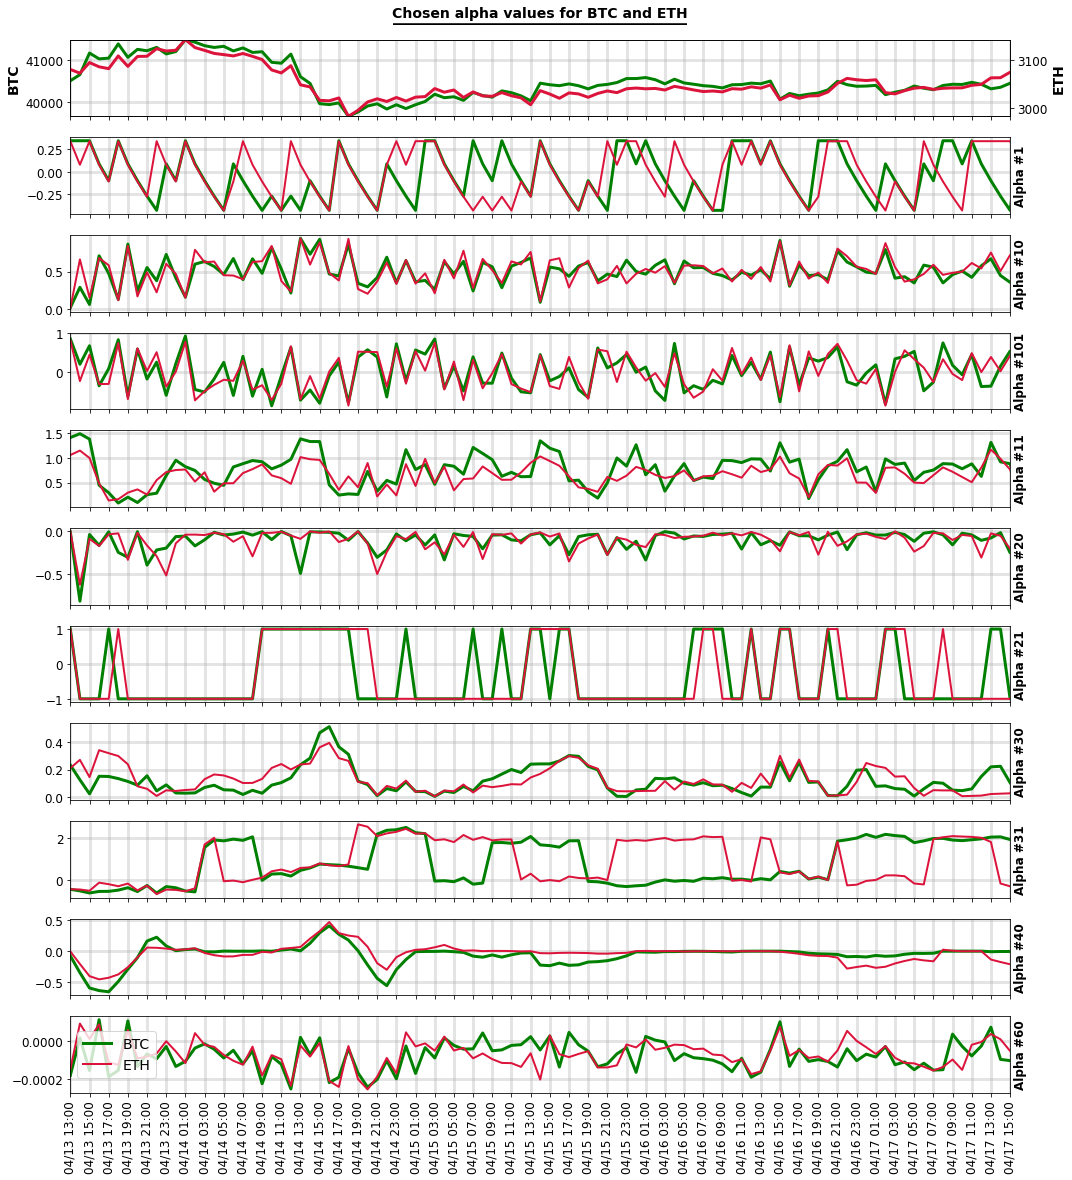

In [251]:
choose = {"BTC": "green", "ETH": "crimson"} # be sure to only test 2 cryptos.
alphaReduced = alphaDF.swaplevel(axis = "columns")
alphaReduced = alphaReduced[choose.keys()].iloc[-100 :]
figure, axes = matplotlib.pyplot.subplots(sharex = True,
    nrows = len(alpha) + 1, figsize = (15, (len(alpha) + 1) * 1.5))
alphAxes = dict(zip(alpha.keys(), axes[1 :]))
xTicks = alphaReduced.index[:: alphaReduced.shape[0] // 50]

label_L, label_R = choose.keys()
color_L, color_R = choose.values()
ax_L, ax_R = axes[0], axes[0].twinx()
ax_L.grid(True, lw = 3, alpha = 1/3)
price_L, price_R = marketDF["close"][[label_L, label_R]].iloc[-100 :].values.T
ax_L.plot(alphaReduced.index, price_L, color = color_L, lw = 3)
ax_L.set_ylabel(label_L, fontsize = 14, fontweight = "bold")
ax_L.tick_params(labelsize = 12) ; ax_L.set_ylim(price_L.min(), price_L.max())
ax_R.plot(alphaReduced.index, price_R, color = color_R, lw = 3)
ax_R.set_ylabel(label_R, fontsize = 14, fontweight = "bold")
ax_R.tick_params(labelsize = 12) ; ax_R.set_ylim(price_R.min(), price_R.max())
title = "Chosen alpha values for %s and %s" % (label_L, label_R)
title += "\n" + "‾" * int(len(title) * 1.2)
ax_L.set_title(title, fontsize = 14, fontweight = "bold")

progBar = ProgBar(items, 40, "Drawing alpha")
for nAlpha, alphAxis in alphAxes.items():

    alphAxis.plot(alphaReduced.index, alphaReduced["BTC"][nAlpha],
        label = "BTC", axes = alphAxis, color = choose["BTC"], lw = 3)
    alphAxis.plot(alphaReduced.index, alphaReduced["ETH"][nAlpha],
        label = "ETH", axes = alphAxis, color = choose["ETH"], lw = 2)
    alphAxis.grid(True, lw = 3, alpha = 1/3)
    alphAxis.set_ylabel("Alpha #%d" % nAlpha,
        fontweight = "bold", fontsize = 12)
    alphAxis.tick_params(labelsize = 12)
    alphAxis.yaxis.set_label_position("right")
    alphAxis.set_xticks([]) ; progBar.show()

alphAxis.set_xticks(xTicks)
alphAxis.legend(fontsize = 14, ncol = 1, loc = "center left")
alphAxis.set_xticklabels(xTicks.strftime("%m/%d %H:%M"), rotation = 90)
alphAxis.set_xlim(xTicks[0], xTicks[-1])
figure.set_tight_layout((0, 0, 1, 1))
figure.savefig(title.split("\n")[0] + ".jpg", dpi = 120)

<hr>

#### Returns and drawdown

A new "<code>returnDF</code>" <code>DataFrame</code> is built with the same structure as the formers, but with columns specified in "<code>metrics</code>" instead of OHLC. Log returns are calculated, because of their additive nature between timestamps. Values will be analyzed later.

In [5]:
marketDF = swap(marketDF, byOHLC = True)

metrics = ["logReturns", "cumReturns", "drawdown"]
returnDF = DataFrame(numpy.nan, index = marketDF.index,
    columns = MultiIndex.from_product((metrics, quotes)))
returns = marketDF["close"].pct_change().fillna(0)
returnDF["logReturns"] = numpy.log(1 + returns)
cumLogReturns = returnDF["logReturns"].cumsum() + 1
returnDF["cumReturns"] = numpy.exp(cumLogReturns - 1) - 1
returnDF["drawdown"] = 1 - cumLogReturns / cumLogReturns.cummax()

<hr>

#### Daily resampling

A new "<code>dailyDF</code>" <code>DataFrame</code> is built from compressing the OHLCV data to a daily timeframe. This is done to obtain certain daily / monthly / annual stats later on.

In [6]:
marketDF = swap(marketDF, byOHLC = True)
dailyDF = DataFrame(columns = marketDF.columns)
reframe = {"open": "first", "high": "max", "low": "min", "close": "last", "volume": "sum"}
for column in columns: dailyDF[column] = marketDF[column].resample("1D").agg(reframe[column])

<hr>

#### Statistics

Finally, "`statDF`" is calculated from past `DataFrame`s. Row indexes are the cryptocurrency labels from Binance, and columns are the different statistics and metrics of interest. They mostly consist of:
* "`upCandles`" and "`dnCandles`": amount of bull and bear candles in original OHLC data.
<br>Reapplied in "`upDays`" and "`dnDays`" but for the daily data resampled above.
* "`retMean`" and "`retStDv`": mean and standard deviation of log returns.
<br>Reapplied in "`retMean_D`" and "`retStDv_D`" but for the daily data resampled above.
<br>When focused on the last 30 days (month), average daily return is labelled "`retMean_D_last`".
* "`retRange`" as the range/amplitude of recorded return values (max - min).
* "`Sharpe`" as the ratio between mean and standard deviation for original and daily data.
<br>For monthly ("...`_M`") and annualized ("...`_Y`") cases, it is calculated as "$S(n) = \sqrt{n}\;S_D$"
<br>Where "$S$" is the daily Sharpe ratio, and "$n$" is the amount of tradeable days considered in each period. <br>Normally, "$n = 20$" monthly, "$n = 252$" yearly. But crypto markets are open 24/7 all year. So: "$n = 30$" and "$n = 365$" respectively.
* "`pNLoss`" is the theoretical probability "$p(x < 0)$" of getting a loss if the individual/daily/monthly/yearly returns were considered to have a Gaussian Normal distribution with probability density function "$N(x)$". In the ideal case in which calculated (sample) mean and standard deviation are equal to their theoretical counterparts "$(\mu, \sigma)$" , then:
$$ p(x < 0) = N(\frac{0 - \mu}{\sigma}) = N(-\frac{\mu}{\sigma}) = N(-S)$$
* "`avgDrawdown`" and "`maxDrawdown`" as the mean and maximum value of the calculated drawdown timeseries.
* "`Calmar`" and "`Sterling`" as "$\mu$/{mean drawdown}" and "$\mu$/{max drawdown}" where "$\mu$" is the average return rate in the original data.

In [7]:
marketDF = swap(marketDF, byOHLC = True)
statDF = DataFrame(index = quotes)
nMonthly, nYearly = 30, 365

statDF["upCandles"] = (marketDF["close"].diff() > 0).sum(axis = "index")
statDF["dnCandles"] = (marketDF["close"].diff() < 0).sum(axis = "index")
statDF["retMean"] = returnDF["logReturns"].mean()
statDF["retStDv"] = returnDF["logReturns"].std()
statDF["Sharpe"] = statDF["retMean"] / statDF["retStDv"]
statDF["pNLoss"] = norm.cdf(-statDF["Sharpe"])
statDF["retRange"] = returnDF["logReturns"].max() - returnDF["logReturns"].min()

statDF["upDays"] = (dailyDF["close"].diff() > 0).sum(axis = "index")
statDF["dnDays"] = (dailyDF["close"].diff() < 0).sum(axis = "index")
statDF["retMean_D"] = dailyDF["close"].pct_change().mean()
statDF["retMean_D_last"] = dailyDF["close"].pct_change().iloc[-30:].mean()
statDF["retStDv_D"] = dailyDF["close"].pct_change().std()

statDF["Sharpe_D"] = statDF["retMean_D"] / statDF["retStDv_D"]
statDF["pNLoss_D"] = norm.cdf(-statDF["Sharpe_D"])
statDF["Sharpe_M"] = numpy.sqrt(nMonthly) * statDF["Sharpe_D"]
statDF["pNLoss_M"] = norm.cdf(-statDF["Sharpe_M"])
statDF["Sharpe_Y"] = numpy.sqrt(nYearly) * statDF["Sharpe_D"]
statDF["pNLoss_Y"] = norm.cdf(-statDF["Sharpe_Y"])

statDF["avgDrawdown"] = returnDF["drawdown"].mean()
statDF["maxDrawdown"] = returnDF["drawdown"].max()
statDF["Calmar"] = statDF["retMean"] / statDF["avgDrawdown"]
statDF["Sterling"] = statDF["retMean"] / statDF["maxDrawdown"]

<hr>

### Result visualization and analysis

Through the "`CCXT.plotCMC`" instance method, we can draw the market cap histogram sorted from left to right. Result should be as shown below. *(If wishing to execute cell below, delete the* "`%%capture`" *line)*

<center><img src = "https://raw.githubusercontent.com/gsolaril/topCMC/main/Top%20CMC%2050.jpg" width = 90%></src></center>

Most rise over the 2-billion USD benchmark. Differences are approximately exponential, so log vertical axes are suggested.

In [8]:
%%capture
Figure = myCMC.plotCMC(figsize = (15, 5), saveJPG = True)

Most important fact in a strategy is to register at least a minimal edge. In that case, we would specifically prefer to keep those whose average daily ("`retMean_D`") is positive at long-term (or at least, the extent provided by the dataframe). But we should also consider recent trends. Therefore the average daily volume of these last 30 days ("`retMean_D_last`") would prove useful.

It is necessary, however, to consider short-term trends as a manifestation of the actual scenario. Cryptocurrencies are usually subject to sudden price booms. In that case, we shall take into account last month's daily average too.

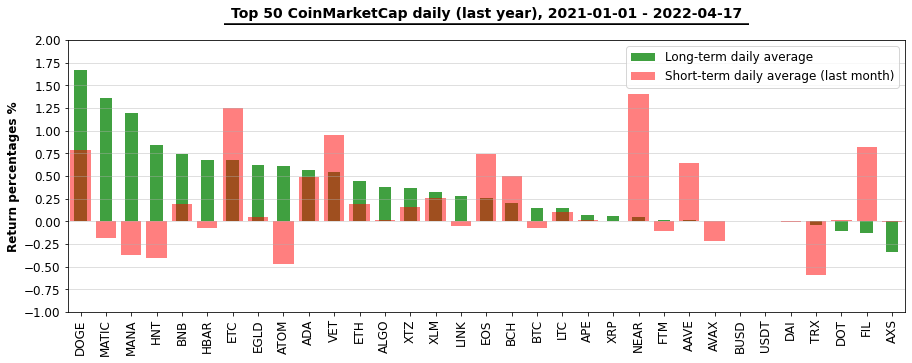

In [9]:
pctReturn = statDF["retMean_D"] * 100 # Percentages
t1, t2 = marketDF.index[[0, -1]].strftime("%Y-%m-%d")
pctReturn.sort_values(inplace = True, ascending = False)
axes = pctReturn.plot.bar(figsize = (15, 5), alpha = 0.75,
    label = "Long-term daily average", color = "green")
axes.set_ylabel("Return percentages %", fontsize = 12, fontweight = "bold")
title = "Top 50 CoinMarketCap daily (last year), %s - %s" % (t1, t2)
title += "\n" + "‾" * int(len(title) * 1.2)
axes.set_title(title, fontsize = 14, fontweight = "bold")
axes.grid(True, axis = "y", alpha = 0.5)
axes.tick_params(labelsize = 12)

pctReturn_2 = statDF["retMean_D_last"] * 100 # Percentages
axes.bar(range(*pctReturn_2.shape), pctReturn_2[pctReturn.index],
    label = "Short-term daily average (last month)", color = "red", alpha = 0.5);

yTicks = axes.get_yticks()
nTicks = 2 * len(yTicks) - 1
yTicks = numpy.linspace(*yTicks[[0, -1]], nTicks)
axes.set_yticks(yTicks)
axes.legend(fontsize = 12);

The proposal might be to pay special attention to the **approval** of those few cryptocurrencies from the list that have either:
<ol><li> A strong short-term red average (larger than 0.5%)
</li><li> A very strong long-term green average (larger than 1%)
</li><li> The ones whose both daily average returns are above 0.25%.
</li></ol>

After this selection, we could sort the resulting quotes by their characteristic ratios: Sharpes, Calmars and Sterlings. But particularly interesting is the fact that most drawdown ratios have a quite high degree of correlation with Sharpe, so then we can follow this fact and classify the selected cryptocurrencies by their daily Sharpe ratio being greater than zero, trusting that we are not leaving aside drawdown as a factor.

Notice that it is possible that some of the "`approved`" assets may not seem so profitable in the figure above (e.g.: XLM). It does not display each volatility however, which is perhaps Sharpe ratio's main "enemy". High Sharpe ratios with low periodic returns may perhaps be a "safer" asset for the long term then.

In [10]:
print("Volatility to drawdown-ratio correlations:",
    statDF[["Sharpe", "Sterling", "Calmar"]].corr().iloc[[0]])
    
cond_1 = numpy.where(statDF["retMean_D_last"] > 0.005)
cond_2 = numpy.where(statDF["retMean_D"] > 0.01)
cond_3 = numpy.where((statDF["retMean_D"] > 0.0025)
              & (statDF["retMean_D_last"] > 0.0025))
cond_123 = numpy.unique(numpy.hstack((cond_1, cond_2, cond_3)))
ratios = ["Sharpe", "Sharpe_D", "Sharpe_M", "Sharpe_Y", "Calmar", "Sterling"]
approved = statDF[ratios].iloc[cond_123]
approved = approved.loc[approved["Sharpe"] > 0]
print("Approved cryptocurrencies -> " + ", ".join(approved.index))

'Volatility to drawdown-ratio correlations:'

,Sharpe,Sterling,Calmar
Sharpe,1.0,0.836116,0.845302


'Approved cryptocurrencies -> ADA, DOGE, NEAR, MATIC, ETC, XLM, MANA, VET'

### Portfolio backtest

We shall build a small test cryptocurrency set for the matter, selecting 5 favorable cryptocurrencies. One suitable criterion is to take a set as less correlated as possible. By computing the correlation matrix between the approved ones up to now, we can discard those that have the highest mean correlation coefficient.

In [11]:
corrs = returnDF["logReturns"][approved.index]
corrs = corrs.corr().mean().sort_values()
lowCorr = list(corrs.index[:5])
corrs = corrs.to_dict().items()
corrs = ["%s: %.2f" % (quote, value) for quote, value in corrs]
print("Mean correlation coefficients:", ", ".join(corrs))

'Mean correlation coefficients:'

'NEAR: 0.28, DOGE: 0.40, MANA: 0.48, MATIC: 0.51, ETC: 0.54, XLM: 0.54, ADA: 0.57, VET: 0.58'

Next step is to allocate position sizes. Aiming towards a stable and balanced portfolio, the amount of investment in each asset should scale to:
* Their *actual price*: {**Cheaper** | **more expensive**} cryptocurrencies should imply a {**larger** | **smaller**} amount of base units (coins) to keep allocation percentage as invariant as possible.
* Their *volatility*: Sharpe is the mean-return-to-volatility ratio, so if all volatilities are scaled up or down to a particular value, returns should be scaled up or down too in the same measure. More volatile positions should therefore be smaller so as to increase global Sharpe ratio.

A starting capital ("`cap`" in USD/cash) should be considered, which will be 100% invested in said selection. We will therefore create a new class "`Portfolio`" to make a simple simulation of how the set would have performed in the past with the downloaded data.

In [ ]:
class Portfolio:

    def __init__(self, cap: float,
            assetLabels: list[str],      # tickers
            assetLongVols: list[float]): # long-term volatilities

        self.cap = cap ; self.labels = assetLabels
        meanVol = numpy.mean(assetLongVols) # establish mean volatility as benchmark
        self.sizes = meanVol / assetLongVols # invest inversely prop to volatility
        self.sizes = self.sizes / sum(self.sizes) # should normalize to percentages
        self.sizes = self.cap * self.sizes # "sizes" should now include cash amount
        self.btDF = self.ftDF = self.stats = None # placeholders for future results
    
    def backtest(self, logReturns: DataFrame):

        self.btDF = DataFrame(columns = self.labels, index = logReturns.index)

        self.logReturns = logReturns
        cumReturns = numpy.exp(logReturns.cumsum()) # "cumReturns" keeps time series of capital growth in %.
        self.btDF = self.sizes * cumReturns # so mult. by each cash amount, should keep capital growth in $. 
        self.btDF["total"] = self.btDF.sum(axis = "columns") # recalculate returns.
        self.btDF["logReturns"] = self.btDF["total"].pct_change().fillna(0)
        self.btDF["logReturns"] = numpy.log(1 + self.btDF["logReturns"])
        cumLogReturns = self.btDF["logReturns"].cumsum() + 1
        self.btDF["cumReturns"] = numpy.exp(cumLogReturns - 1) - 1
        self.btDF["drawdown"] = 1 - cumLogReturns / cumLogReturns.cummax()

<b>Note:</b> lack of market data from Binance for any cryptocurrency ends up in an horizontal segment in the following graph. That is because "`nan`" values in the "`marketDF`" `DataFrame` generation were filled with (all equal) past close prices and zero volumes.

The following figure would show that the volatility (log) of the net portfolio would be smaller than each one of its components, mostly due to diversification. The intention is: as volatilities are scaled up or down by each allocation size, and therefore "equalized" (almost), the portfolio volatility would be theoretically reduced (divided) by the square root of the amount of components.

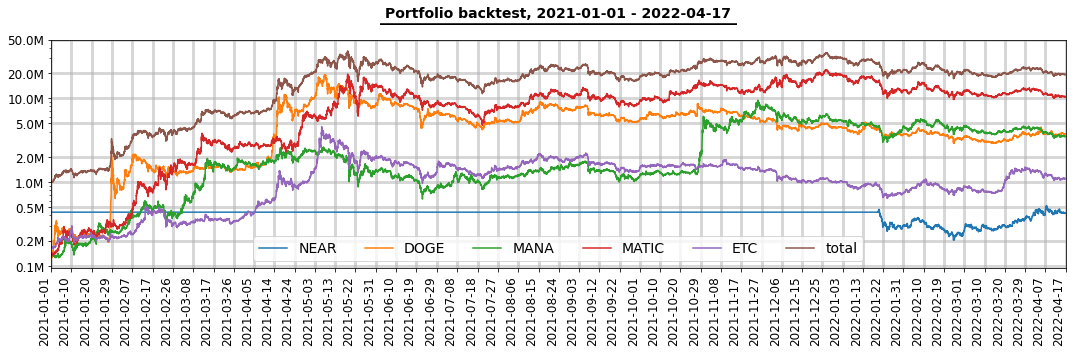

In [130]:
portfolio = Portfolio(1000000, assetLabels = lowCorr,
        assetLongVols = statDF.loc[lowCorr, "retStDv"])

portfolio.backtest(logReturns = returnDF["logReturns"][lowCorr])
toPlot = portfolio.btDF[lowCorr + ["total"]].copy()
axes = toPlot.plot(figsize = (15, 5))
axes.set_yscale("log")
yLogRange = toPlot.min().min(), toPlot.max().max()
yLogRange = MyCMC.logRange(*yLogRange)
axes.set_yticks(yLogRange)
yTicks = [str(x / 1e6) + "M" for x in yLogRange]
axes.set_yticklabels(yTicks, fontsize = 12)

title = "Portfolio backtest, %s - %s" % (t1, t2)
title += "\n" + "‾" * int(len(title) * 1.2)
axes.set_title(title, fontsize = 14, fontweight = "bold")
axes.tick_params("x", labelsize = 12, rotation = 90)

xTicks = toPlot.index
xTicks = xTicks[:: len(xTicks) // 50]
axes.set_xlim(xTicks[0], xTicks[-1])
axes.grid(True, lw = 3, alpha = 0.5)
axes.set_xticks(xTicks) ; axes.set_xlabel("")
axes.legend(fontsize = 14, ncol = len(lowCorr) + 1)
axes.figure.set_tight_layout((0, 0, 1, 1))
axes.figure.savefig(title.split("\n")[0] + ".jpg", dpi = 120)

### Future projection

Having all the statistics of said portfolio within reach, then a simple Montecarlo simulation could be generated for a bit longer in the future to have an early idea of how would the portfolio continue performing.

Several random value timeseries would draw an "area" in the chart. Let the worst and the best case be taken into account as the lowest and highest border of such area, respectively.

In [154]:
class Portfolio(Portfolio):

    def forwardtest(self, until: Timestamp, sims: int = 100):

        assert isinstance(self.btDF, DataFrame), \
            "\".backtest\" should be executed first."
        delta = self.btDF.index[-1] - self.btDF.index[-2]
        futureIndex = numpy.arange(self.btDF.index[-1], until, delta)[1 :]
        mean = self.logReturns.mean(axis = "index")
        stdv = self.logReturns.std(axis = "index")
        rMinWalk = rMaxWalk = None # placeholder for best and worst cases.
        progBar = ProgBar(items = sims, width = 40, verbose = "Sim")
        for sim in range(sims):  # sequence of random numbers "N(0, 1)":
            rWalk = numpy.random.randn(len(futureIndex), len(self.labels)) 
            rWalk = DataFrame(rWalk, index = futureIndex, columns = self.labels).shift(1)
            rWalk = 1 + (mean + rWalk * stdv).cumsum() # random numbers "N(mean, stdv)"
            rWalk.fillna(1, inplace = True) # Beginning accounts for starting capital.
            if isinstance(rMinWalk, DataFrame):
                for quote in self.labels:
                    # worst case as the timeseries' area's "floor"
                    rMinWalk[quote] = concat((rMinWalk, rWalk),
                        axis = "columns").min(axis = "columns")
                    # best case as the timeseries' area's "ceiling"
                    rMaxWalk[quote] = concat((rMaxWalk, rWalk),
                        axis = "columns").max(axis = "columns")
            else: rMinWalk, rMaxWalk = rWalk.copy(), rWalk.copy()
            progBar.show()

        endBT = self.btDF[self.labels].iloc[-1]
        # starting cap is past backtest's ending cap:
        rMinWalk *= endBT ; rMaxWalk *= endBT
        rMidWalk = (rMinWalk + rMaxWalk) / 2
        self.ftDF = {"min": rMinWalk, "mid": rMidWalk, "max": rMaxWalk}
        for key, rWalk in self.ftDF.items():
            # re-calc all return timeseries for each case:
            rWalk["total"] = rWalk.sum(axis = "columns")
            rWalk["logReturns"] = rWalk["total"].pct_change().fillna(0)
            rWalk["logReturns"] = numpy.log(1 + rWalk["logReturns"])
            cumLogReturns = rWalk["logReturns"].cumsum() + 1
            rWalk["cumReturns"] = numpy.exp(cumLogReturns - 1) - 1
            rWalk["drawdown"] = 1 - cumLogReturns / cumLogReturns.cummax()
            self.ftDF[key] = rWalk

Highly volatile portfolios with low positive Sharpe ratios would have a positive mean growth (a slightly upward slope), but a wide area. Optimizing the strategy would require to shrink such area and increase the mid-curve slope.

**Note:** Watch out for high "`sims`" values, which could lag the execution of the next cell.

[========================================] 100% | Sim: 100 / 100

C:\DEV\Conda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Oreo\AppData\Local\Temp/ipykernel_4836/311153158.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(yTicks, fontsize = 12)


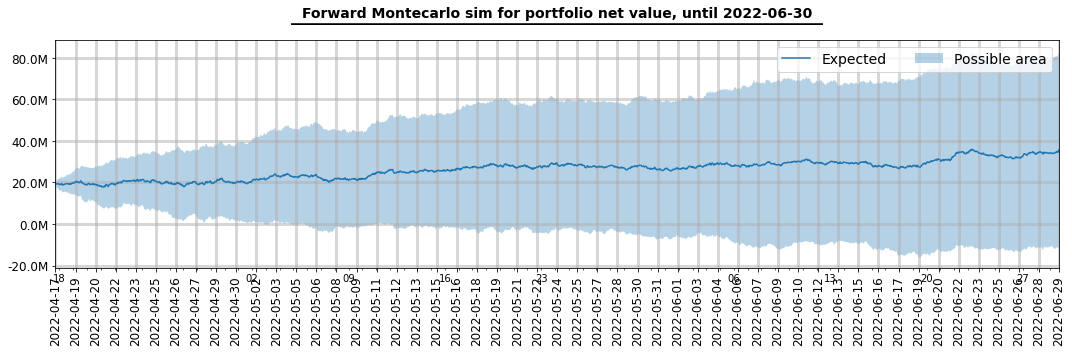

In [160]:
portfolio = Portfolio(1000000, assetLabels = lowCorr,
        assetLongVols = statDF.loc[lowCorr, "retStDv"])

portfolio.backtest(logReturns = returnDF["logReturns"][lowCorr])
portfolio.forwardtest(until = datetime("2022-07-01"), sims = 100) # sims <= 100

toPlot = concat(portfolio.ftDF, axis = "columns")
toPlot = toPlot.swaplevel(axis = "columns")["total"]
toPlot = toPlot.replace(numpy.inf, numpy.nan)
axes = toPlot["mid"].plot(figsize = (15, 5), label = "Expected")
axes.fill_between(alpha = 1/3, label = "Possible area",
    x = toPlot.index, y1 = toPlot["min"], y2 = toPlot["max"])

yRange = axes.get_yticks()
yTicks = [str(x / 1e6) + "M" for x in yRange]
axes.set_yticklabels(yTicks, fontsize = 12)

t1b = toPlot.index[0].strftime("%Y-%m-%d")
t2b = toPlot.index[-1].strftime("%Y-%m-%d")
title = "Forward projections for "
title += "portfolio net value, until %s" % t2b
title += "\n" + "‾" * int(len(title) * 1.2)
axes.set_title(title, fontsize = 14, fontweight = "bold")
axes.tick_params("x", labelsize = 12, rotation = 90)

xTicks = toPlot.index
xTicks = xTicks[:: len(xTicks) // 50]
axes.set_xlim(xTicks[0], xTicks[-1])
axes.grid(True, lw = 3, alpha = 0.5)
axes.set_xticks(xTicks) ; axes.set_xlabel("")
axes.set_xticklabels(xTicks.strftime("%Y-%m-%d"))
axes.legend(fontsize = 14, ncol = len(lowCorr) + 1)
axes.figure.set_tight_layout((0, 0, 1, 1))
axes.figure.savefig(title.split("\n")[0] + ".jpg", dpi = 120)

We can finally see some stats of the resulting portfolio.

In [282]:
class Portfolio(Portfolio):

    def stats(self):

        assert isinstance(self.btDF, DataFrame), \
            "\".backtest\" should be executed first."
        stats = Series(dtype = float)
        logReturns = self.btDF["total"].pct_change()
        logReturns = numpy.log(1 + logReturns)
        stats["upCandles"] = (logReturns > 0).sum()
        stats["dnCandles"] = (logReturns < 0).sum()
        stats["retMean"] = logReturns.mean()
        stats["retStDv"] = logReturns.std()
        stats["retRange"] = logReturns.max() - logReturns.min()
        stats["Sharpe"] = stats["retMean"] / stats["retStDv"]
        stats["pNLoss"] = norm.cdf(- stats["Sharpe"])
        logReturns_D = logReturns.resample("1D").agg("sum")
        stats["retMean_D"] = logReturns_D.mean()
        stats["retStDv_D"] = logReturns_D.std()
        stats["Sharpe_D"] = stats["retMean_D"] / stats["retStDv_D"]
        stats["pNLoss_D"] = norm.cdf(- stats["Sharpe_D"])
        stats["Sharpe_M"] = numpy.sqrt(30) * stats["Sharpe_D"]
        stats["pNLoss_M"] = norm.cdf(- stats["Sharpe_M"])
        stats["Sharpe_Y"] = numpy.sqrt(365) * stats["Sharpe_D"]
        stats["pNLoss_M"] = norm.cdf(- stats["Sharpe_Y"])
        cumReturns = 1 + logReturns.cumsum()
        drawdown = 1 - cumReturns / cumReturns.cummax()
        stats["avgDrawdown"] = drawdown.mean()
        stats["maxDrawdown"] = drawdown.max()
        stats["Calmar"] = stats["retMean"] / stats["avgDrawdown"]
        stats["Sterling"] = stats["retMean"] / stats["maxDrawdown"]
        return stats

portfolio = Portfolio(1000000, assetLabels = lowCorr,
        assetLongVols = statDF.loc[lowCorr, "retStDv"])

portfolio.backtest(logReturns = returnDF["logReturns"][lowCorr])
portfolioStats = portfolio.stats()
allocation = DataFrame(portfolio.sizes).transpose()
allocation.index = ["USD"]
cap = portfolio.sizes.sum()
allocation.loc["%"] = 100 * allocation.loc["USD"] / cap
print("Portfolio sizes:", allocation.round(2))
print("Portfolio stats:", portfolioStats)

'Portfolio sizes:'

,NEAR,DOGE,MANA,MATIC,ETC
USD,435891.26,125066.66,135968.52,136086.60,166986.96
%,43.59,12.51,13.60,13.61,16.70


'Portfolio stats:'

upCandles      5860.000000
dnCandles      5449.000000
retMean           0.000262
retStDv           0.015631
retRange          0.507872
Sharpe            0.016745
pNLoss            0.493320
retMean_D         0.006271
retStDv_D         0.071659
Sharpe_D          0.087519
pNLoss_D          0.465130
Sharpe_M          0.479361
pNLoss_M          0.047258
Sharpe_Y          1.672046
avgDrawdown       0.090661
maxDrawdown       0.260888
Calmar            0.002887
Sterling          0.001003
dtype: float64